# Projekt zur Spurerkennung im Wahlfach "Digitale Bildverarbeitung" 

In diesem Jupyter-Notebook wird eine Fahrbahnmarkierungserkennung implementiert. Anhand von Bildern und Videos von Udacity und KITTI wird diese Erkennung auf verschiedenste Weise getestet.

Um eine Fahrbahn erkennen zu können müssen folgende Schritte während des Programmablaufs abgearbeitet werden:

    - Kamerakalibrierung
    - Perspektivtransformation
    - Maskieren des Bildes mit gelben und weißen Farbmasken
    - "Sliding Windows"
    - Berechnung der Polynome für die Eingrenzung der Fahrbahn
    - Rücktransformation der berechneten Punkte der Polynome
    - Einzeichnen der Fläche zwischen den Polynomen

Im folgenden werden die jeweils verwendeten Funktionen genauer erklärt, am Ende finden sich die Bilder zur Kamerakalibrierung sowie zur Spurerkennung.

<sup>Bearbeitet wurde das Projekt von Alex (), Eddi () und Marcel Fleck (9611872)</sup>

In [1]:
# imports
import cv2 as cv
import numpy as np
import time
from matplotlib import pyplot as plt
import glob
from prettytable import PrettyTable

# Time Measurement

Diese Funktionen dienen der Bestimmung von zeitaufwändigen Arbeitsschritten, um eine Verbesserung der Framerate zu erleichtern.

In einem Array wird ein Objekt hinterlegt, in dem der Name, die Start- und Endzeit sowie die Anzahl an Aufrufen hinterlegt wird (siehe ```start_time_measurement``` und ```end_time_measurement```).

Diese Informationen werden dann in einer Tabelle nach Beendigung des Programmdurchlaufs visualisiert (siehe ```analyse_time_measurement```).

In [2]:
time_measurements = {}

def start_time_measurement(eventName):
    add = False
    if eventName not in time_measurements:
        time_measurements[eventName] = {
            "name": eventName,
            "start": [],
            "end": [],
            "count": 0
        }
        add = True
    elif len(time_measurements[eventName]["start"]) > len(time_measurements[eventName]["end"]):
        print(f"Time measure error: Event '{eventName}' not finished before reassignment!")
    else:
       add = True
    
    #start measurement as late as possible
    if add:
        time_measurements[eventName]["start"].append(time.perf_counter_ns())

def end_time_measurement(eventName):
    #end measurement as fast as possible
    temp_time = time.perf_counter_ns()
    if eventName not in time_measurements:
        print(f"Time measure error: Event '{eventName}' not defined!")
    elif len(time_measurements[eventName]["end"]) >= len(time_measurements[eventName]["start"]):
        print(f"Time measure error: Event '{eventName}' not started before reassignment!")
    else:
        time_measurements[eventName]["end"].append(temp_time)
        time_measurements[eventName]["count"] += 1

def analyse_time_measurements():
    time_measurements_table = PrettyTable(["Name", "Avg. [ms]", "Min. [ms]", "Max. [ms]", "Occurrences [compl.]"])
    time_measurements_table.align["Name"] = "l"
    time_measurements_table.align["Avg. [ms]"] = "r"
    time_measurements_table.align["Min. [ms]"] = "r"
    time_measurements_table.align["Max. [ms]"] = "r"
    time_measurements_table.align["Occurrences [compl.]"] = "r"
    for key, event in time_measurements.items():
        timings = []
        if len(event["start"]) != len(event["end"]):
            print(f"Time measure error: Event '{key}' has different amounts of values for start and end times!")
        else:
            #exclude 0 values
            for i in range(len(event["start"])):
                timing = (event["end"][i] - event["start"][i])
                if timing >= 0:
                    timing = timing / (1000 * 1000) #convert from ns to ms
                    timings.append(timing)

            event["min"] = min(timings) 
            event["max"] = max(timings)
            event["avg"] = sum(timings) / len(event["start"])

            time_measurements_table.add_row([key, '{0:.2f}'.format(event["avg"]), '{0:.2f}'.format(event["min"]), '{0:.2f}'.format(event["max"]), event["count"]])
    print(time_measurements_table)

# Kamerakalibrierung

Die Abbildung eines 3D-Objekts auf eine 2D-Bildebene mit einer Kamera wird durch die internen Größen einer Kamera beeinflusst. Dazu gehören zum Beispiel die Bildmitte, die Brennweite und auch Kameraverzerrungsparameter.

Mit Hilfe der Kamerakalibrierung werden die sogenannten "intrinsische" und "extrinsische" Parameter berechnet. Intrinsische Parameter beschreiben die Kalibriermatrix (Kamera zu Pixel), während die extrinsischen Parameter die Beziehung zwischen dem Koordinatensystem der Kamera und dem Welt-Koordinatensystem beschreiben (Welt zu Kamera).

Zusammen bilden diese Parameter eine Projektionsmatrix, die es ermöglicht, gemachte Bilder im Welt-Koordinatensystem darzustellen (die Bilder werden entzerrt). 

In folgendem Abschnitt wird die Kamera mit Hilfe von Schachbrett-Bildern kalibriert. Die Ergebnisse der Kalibrierung sind hier auch zu sehen.

Mit den unten definierten Funktionen (siehe ```undistort_image``` und ```undistort_image_remap```) werden dann die Frames der Videos anhand der berechneten Transformations-Matrix entzerrt, um eine tatsächliche Darstellung im Welt-Koordinatensystem zu erhalten. Eine Implementierung von zwei Funktionen lässt mit dem Erreichen von einer ungefähr 50% schnelleren Verarbeitung begründen.

In [3]:
# size of chessboard, minimum error with (7, 6), but there were severe artefacts at the borders (see error calculation at the end)
x, y = 9, 6

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((y * x, 3), np.float32)
objp[:, :2] = np.mgrid[0:x, 0:y].T.reshape(-1, 2)
# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.


images = glob.glob("./img/Udacity/calib/*.jpg")
for i, fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (x, y), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(
            gray, corners, (11, 11), (-1, -1), criteria
        )  # improve accuracy of corners
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))


def undistort_image(img):
    h, w = img.shape[:2]

    img_undist = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    return img_undist[y : y + h, x : x + w]


# ~50% faster than undistort_image()
def undistort_image_remap(img):
    h, w = img.shape[:2]
    mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w, h), 5)
    dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
    # crop the image
    x, y, w, h = roi
    return dst[y : y + h, x : x + w]

# Perspektivtransformation

Die Perspektivtransformation wird verwendet, um die "Region of Interest" festzulegen. Dadurch muss nicht mehr das gesamte Bild verarbeitet werden, sondern es kann nur ein der Bereich, in dem sich die Fahrspur befindet, zur Verarbeitung genutzt werden.

Hierbei werden vier feste Punkte im originalen Bild ausgewählt (siehe Abbildung 1). Diese Punkte werden dann in einem Bild mit den selben Dimensionen wie das Originalbild dargestellt, um eine rechteckige Beziehung zwischen den Punkten herzustellen.

<p align="center">
  <img src="img/documentation/perspectiveTransformation.png" />
  <br>
  <em>Abbildung 1: Beispiel füe implementierte Perspektivtransformation</em>
</p>






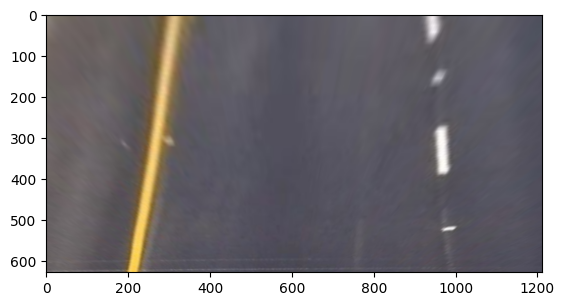

In [34]:
# udacity images
src_udacity = np.float32([[191, 628], [531, 404], [1021, 628], [681, 404]])
dst_udacity = np.float32([[150, 720], [150, 10], [1000, 720], [1000, 10]])
M_warp = cv.getPerspectiveTransform(src_udacity, dst_udacity)
M_rewarp = cv.getPerspectiveTransform(dst_udacity, src_udacity)


def warp_image_udacity(img):
    img = cv.warpPerspective(img, M_warp, (img.shape[1], img.shape[0]))
    # image = cv.resize(
    #     image, (int(img.shape[1] / 2), int(img.shape[0] / 2))
    # )  # resize to half size
    return img

def rewarp_image_udacity(img):
    # image = cv.resize(
    #     img, (int(img.shape[1] * 2), int(img.shape[0] * 2))
    # ) 
    # img = cv.warpPerspective(img, M_rewarp, (img.shape[1], img.shape[0]))
    img = cv.warpPerspective(img, M_rewarp, (img.shape[1], img.shape[0]), cv.WARP_INVERSE_MAP)
    return img

def rewarp_points_udacity(points):
    return cv.perspectiveTransform(points, M_rewarp)

test_img = cv.imread("img/Udacity/image001.jpg")
test_img = undistort_image_remap(test_img)
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
test = warp_image_udacity(test_img)
plt.imshow(test)

# Sliding Windows

In [5]:
nwindows = 10
margin = 50
def sliding_windows(frame, window_width=200, minimum_whites=30, show_windows=False):
    # Histogram for image
    hist = np.sum(frame[frame.shape[0]//2:, :], axis=0)
        
    # Take peaks from left and right side of histogramm for starting points and add half margin
    mid = np.int32(hist.shape[0] // 2)
    leftx_start = np.argmax(hist[:mid]) - window_width // 2
    rightx_start = np.argmax(hist[mid:]) + mid + window_width // 2
    # Window height based on number of windows
    window_height = np.int32(frame.shape[0] // nwindows)
    
    # Calc points that are not zero in images
    nonzero = frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Initialize current positions for windows
    leftx_current = leftx_start
    rightx_current = rightx_start

    # Initialize values to be returned -> centers of windows
    lefts_good = np.empty((0,2), dtype=np.int32)
    rights_good = np.empty((0,2), dtype=np.int32)

    # Go through every window
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = frame.shape[0] - (window + 1) * window_height
        win_y_high = frame.shape[0] - window*window_height
        y_mid = (win_y_low + win_y_high) // 2
        
        # Calculate boundaries of the window
        win_xleft_low = leftx_current - window_width  
        win_xleft_high = leftx_current + window_width  
        win_xright_low =  rightx_current - window_width 
        win_xright_high = rightx_current + window_width  
        
        # Identify the pixels that are not zero within window
        left_inds = ((nonzeroy >= win_y_low ) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= win_y_low ) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # If more than minimum pixels are found -> recenter next window
        if len(left_inds) > minimum_whites:
            leftx_current = np.int32(np.mean(nonzerox[left_inds]))
            lefts_good = np.concatenate((lefts_good, [[leftx_current, y_mid]]))
            if show_windows:
                cv.rectangle(frame, (leftx_current - margin, win_y_low),(leftx_current + margin, win_y_high),(255, 255, 255), 2)
        if len(right_inds) > minimum_whites:
            rightx_current = np.int32(np.mean(nonzerox[right_inds]))
            rights_good = np.concatenate((rights_good, [[rightx_current, y_mid]]))
            if show_windows:
                cv.rectangle(frame, (rightx_current - margin, win_y_low),(rightx_current + margin, win_y_high),(255, 255, 255), 2)

    return mid, lefts_good, rights_good

# Polynomes
calculation from center points of the sliding windows

and drawing points on image

In [6]:
#  calculate polynomial from rewaped points
def calculate_polynomial_points(lefts, rights):
    """
    calculate polynomial from rewaped points and then return list of points on the polynomial
    @return: array of points for left and right polynomial
    """
    # calculate polynomial from rewaped points
    left_polynom_values = np.polyfit(lefts[:,1], lefts[:,0], 2)
    right_polynom_values = np.polyfit(rights[:,1], rights[:,0], 2)

    # 750 as x lenght of polynom
    x_axis = np.linspace(0, 750, 750) 

    # calculate y values for left and right line
    left_line_y = left_polynom_values[0]*x_axis**2 + left_polynom_values[1]*x_axis + left_polynom_values[2]
    right_line_y = right_polynom_values[0]*x_axis**2 + right_polynom_values[1]*x_axis + right_polynom_values[2]

    # array of points for left and right line from x and y values
    left_pts = np.array([np.transpose(np.vstack([left_line_y, x_axis]))])
    right_pts = np.array([np.transpose(np.vstack([right_line_y, x_axis]))])

    return left_pts, right_pts

In [7]:
def drawRecOnFrame(frame, left_pts, right_pts):
    """
    input: array of points from left and right lane marking 
     e.g.:
      [[ 281   39]
      [ 971  163]
      [ 958  101]]
    """
    if len(left_pts) + len(right_pts) > 3:
      borderPoints = np.concatenate((np.flip(left_pts, axis=0), right_pts))
      borderPointsRewaped = rewarp_points_udacity(np.array([borderPoints], dtype=np.float32))
      borderPointsRewapedInt = borderPointsRewaped.astype(int)
      # draw in frame
      cv.drawContours(frame, borderPointsRewapedInt, -1, (0,255,0), -1)

# Masking

In [8]:
def applyMasks(frame):
    """
    apply masks to frame and return frame with only lane marking
    """
    ## convert to hsv
    hls_frame = cv.cvtColor(frame, cv.COLOR_BGR2HLS)

    ## mask for white
    white_mask = cv.inRange(hls_frame, (0, 200, 0), (255, 255,255))

    ## mask for yellow
    # yellow_mask = cv.inRange(hls_frame, (20,90,200), (26, 255, 255))
    yellow_mask = cv.inRange(hls_frame, (10,0,100), (40, 255, 255))

    ## final mask and masked
    mask = cv.bitwise_or(white_mask, yellow_mask)
    frame = cv.bitwise_and(frame,frame, mask=mask)

    return frame

# Main


In [9]:
# Open video file
video_file = "project" # "project" or "challenge" or "harder_challenge"
capture = cv.VideoCapture("./img/Udacity/" + video_file + "_video.mp4")

# Check if camera opened successfully
if capture.isOpened() == False:
    print("Error opening video stream or file")

# Start timer for fps counter
start_timer = time.time() - 0.01
frame_count = -1

# Read every frame
while capture.isOpened():
    ret, frame = capture.read()

    # Check if there is another frame
    if frame is None:
        break
    orig = frame.copy()

    # Calculate Frame rate
    frame_count += 1
    ellapsed_time = time.time() - start_timer
    frame_rate = frame_count / ellapsed_time

    if ret == True:
        start_time_measurement("frame")

        # ----------- Preprocessing ---------------
        start_time_measurement("Preprocessing")
        frame = undistort_image_remap(frame)
        orig_undist = frame.copy()
        end_time_measurement("Preprocessing")

        # ---------  Masking ---------------------
        start_time_measurement("masking")
        frame = applyMasks(frame)
        end_time_measurement("masking")

        start_time_measurement("warping")
        frame = warp_image_udacity(frame)
        end_time_measurement("warping")

        #---------- Sliding Windows ----------
        start_time_measurement("sliding windows")
        # Convert to grayscale for sliding windows
        grayscale_frame = cv.cvtColor(frame, cv.COLOR_HLS2BGR)
        grayscale_frame = cv.cvtColor(grayscale_frame, cv.COLOR_BGR2GRAY)
        midpoint, lefts, rights = sliding_windows(grayscale_frame, minimum_whites=margin, show_windows=False)
        end_time_measurement("sliding windows")
  
        #-------------------
        grayscale_frame = orig_undist

        #---------- Calculate polynomial ----------
        start_time_measurement("polynomial calculation")
        left_pts, right_pts = calculate_polynomial_points(lefts, rights)
        end_time_measurement("polynomial calculation")

        # -------- draw plane from all sliding windows ------------
        start_time_measurement("draw plane")
        drawRecOnFrame(grayscale_frame, left_pts[0], right_pts[0])
        end_time_measurement("draw plane")

        # -----------------
        out = grayscale_frame
     

        # Add frame rate to video
        cv.putText(out, "FPS: " + str(round(frame_rate)), (0, 25),
                   cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv.LINE_AA,)
        cv.putText(out, "Frame: " + str(frame_count), (0, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv.LINE_AA,)
        cv.imshow("Frame", out)

        end_time_measurement("frame")

        # Close video with letter 'q'
        if cv.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        break

# When everything done, release the video capture object
capture.release()
cv.destroyAllWindows()

analyse_time_measurements()

+------------------------+-----------+-----------+-----------+----------------------+
| Name                   | Avg. [ms] | Min. [ms] | Max. [ms] | Occurrences [compl.] |
+------------------------+-----------+-----------+-----------+----------------------+
| frame                  |     35.88 |     28.64 |     95.85 |                   59 |
| Preprocessing          |      8.47 |      6.29 |     14.08 |                   59 |
| masking                |      8.08 |      5.99 |     12.71 |                   59 |
| warping                |      2.94 |      2.32 |      5.36 |                   59 |
| sliding windows        |     12.84 |     10.15 |     21.18 |                   59 |
| polynomial calculation |      0.62 |      0.38 |      7.34 |                   59 |
| draw plane             |      0.43 |      0.30 |      0.92 |                   59 |
+------------------------+-----------+-----------+-----------+----------------------+
